In [ ]:
from google.colab import drive

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Dataset_CFD'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = "/content/drive/MyDrive/Dataset_CFD/train"
test_dir = "/content/drive/MyDrive/Dataset_CFD/test"

In [ ]:

# Image data generators for loading and augmenting images
train_datagen = ImageDataGenerator(    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming images are stored in directories 'data/train/laminar', 'data/train/turbulent', etc.
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),  # Resize images
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),  # Resize images
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical'
)

Found 263 images belonging to 2 classes.
Found 69 images belonging to 2 classes.


In [ ]:
total_train_samples = train_generator.samples
total_test_samples = validation_generator.samples

steps_per_epoch = total_train_samples // train_generator.batch_size
validation_steps = total_test_samples // validation_generator.batch_size



In [ ]:
def create_lenet5(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2), strides = (2,2)))
    model.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2), strides = (2,2)))
    model.add(layers.Conv2D(120, kernel_size=(5, 5), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [ ]:
input_shape = (32, 32, 1)
num_classes = 2

model = create_lenet5(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 batch_normalization_14 (Ba  (None, 28, 28, 6)         24        
 tchNormalization)                                               
                                                                 
 average_pooling2d_4 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_17 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_15 (Ba  (None, 10, 10, 16)        64        
 tchNormalization)                                               
                                                      

In [ ]:
# Train the model and store training history
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=64,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Epoch 1/64
8/8 [==============================] - 6s 271ms/step - loss: 0.9019 - accuracy: 0.6147 - val_loss: 0.6856 - val_accuracy: 0.5781
Epoch 2/64
8/8 [==============================] - 2s 237ms/step - loss: 0.6959 - accuracy: 0.6364 - val_loss: 0.6775 - val_accuracy: 0.6094
Epoch 3/64
8/8 [==============================] - 2s 233ms/step - loss: 0.6745 - accuracy: 0.6364 - val_loss: 0.6861 - val_accuracy: 0.5625
Epoch 4/64
8/8 [==============================] - 2s 237ms/step - loss: 0.6706 - accuracy: 0.6364 - val_loss: 0.6840 - val_accuracy: 0.5938
Epoch 5/64
8/8 [==============================] - 2s 314ms/step - loss: 0.6301 - accuracy: 0.6580 - val_loss: 0.6965 - val_accuracy: 0.6094
Epoch 6/64
8/8 [==============================] - 2s 292ms/step - loss: 0.5813 - accuracy: 0.7143 - val_loss: 0.7051 - val_accuracy: 0.4219
Epoch 7/64
8/8 [==============================] - 2s 271ms/step - loss: 0.5945 - accuracy: 0.6758 - val_loss: 0.7192 - val_accuracy: 0.4062
Epoch 8/64
8/8 [====

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print('Validation accuracy:', accuracy)

3/3 [==============================] - 0s 118ms/step - loss: 1.5507 - accuracy: 0.5797
Validation accuracy: 0.5797101259231567


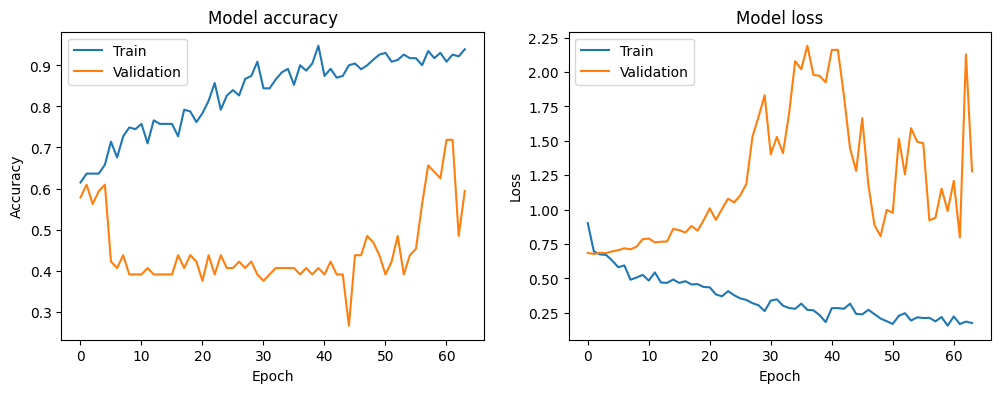

In [ ]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
# ZFNet architecture
def create_zfnet(input_shape, num_classes):
    model = models.Sequential()

    # Conv Layer 1
    model.add(layers.Conv2D(96, kernel_size=(7, 7), strides=(2, 2), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())

    # Conv Layer 2
    model.add(layers.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())

    # Conv Layer 3
    model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same',activation='relu'))

    # Conv Layer 4
    model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same',activation='relu'))

    # Conv Layer 5
    model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())

    # Flatten and Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [ ]:
input_shape = (224, 224, 1)
num_classes = 2

model_ZfNet = create_zfnet(input_shape, num_classes)
model_ZfNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_ZfNet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 109, 109, 96)      4800      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 96)        0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Ba  (None, 54, 54, 96)        384       
 tchNormalization)                                               
                                                                 
 conv2d_20 (Conv2D)          (None, 26, 26, 256)       221440    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                      

In [ ]:
# Image data generators with augmentation
train_datagen_zf = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)
test_datagen_zf = ImageDataGenerator(rescale=1./255)

train_generator_zf = train_datagen_zf.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)
validation_generator_zf = test_datagen_zf.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

Found 263 images belonging to 2 classes.
Found 69 images belonging to 2 classes.


In [ ]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(scheduler)

In [ ]:
# Training the model and storing the training history
history_ZfNet = model_ZfNet.fit(
    train_generator_zf,
    steps_per_epoch=train_generator_zf.samples // train_generator_zf.batch_size,
    epochs=64,
    callbacks=[lr_callback],
    validation_data=validation_generator_zf,
    validation_steps=validation_generator_zf.samples // validation_generator_zf.batch_size
)

Epoch 1/64
8/8 [==============================] - 4s 543ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 1.3188 - val_accuracy: 0.7188 - lr: 1.1080e-04
Epoch 2/64
8/8 [==============================] - 3s 349ms/step - loss: 0.0325 - accuracy: 0.9827 - val_loss: 1.1577 - val_accuracy: 0.7656 - lr: 1.1080e-04
Epoch 3/64
8/8 [==============================] - 3s 352ms/step - loss: 0.0175 - accuracy: 0.9913 - val_loss: 0.9928 - val_accuracy: 0.7969 - lr: 1.1080e-04
Epoch 4/64
8/8 [==============================] - 4s 491ms/step - loss: 0.0168 - accuracy: 0.9957 - val_loss: 0.9372 - val_accuracy: 0.8125 - lr: 1.1080e-04
Epoch 5/64
8/8 [==============================] - 3s 385ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.9440 - val_accuracy: 0.8125 - lr: 1.1080e-04
Epoch 6/64
8/8 [==============================] - 3s 371ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.8798 - val_accuracy: 0.8281 - lr: 1.1080e-04
Epoch 7/64
8/8 [==============================] - 3s 351ms

In [ ]:
# Evaluating the model
loss, accuracy = model_ZfNet.evaluate(validation_generator_zf)
print('Validation accuracy:', accuracy)

3/3 [==============================] - 1s 131ms/step - loss: 0.8048 - accuracy: 0.8551
Validation accuracy: 0.8550724387168884


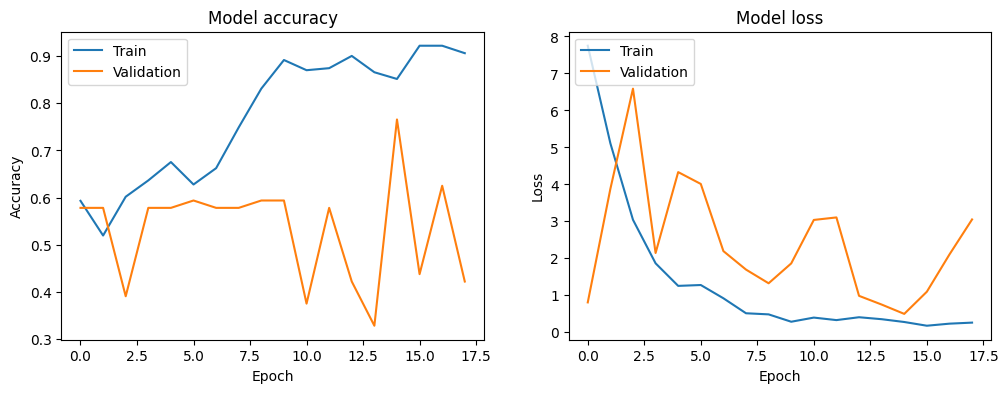

In [ ]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ZfNet.history['accuracy'])
plt.plot(history_ZfNet.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_ZfNet.history['loss'])
plt.plot(history_ZfNet.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()